In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm
from lmfit import Parameters, minimize

import sys
import pickle

sys.path.append("../utils")
from utils import *
from data_retrieve import *
from option import *

In [2]:
combined_df = retrieve_data()
combined_df

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
0,2023-10-25,237.55,17.6858,107.00,33.0793,426.4,15.7900,1.4594
1,2023-10-26,237.25,17.9504,104.45,33.5406,426.8,15.9736,1.4508
2,2023-10-27,237.75,19.6028,104.40,33.4355,424.4,16.3945,1.4478
3,2023-10-30,241.30,19.3503,104.75,33.1531,428.2,15.9477,1.4623
4,2023-10-31,233.85,19.2518,106.90,32.7788,430.6,15.7948,1.4489
...,...,...,...,...,...,...,...,...
248,2024-10-21,272.90,17.7575,126.65,31.1486,526.2,14.1699,0.6532
249,2024-10-22,272.20,18.2963,126.95,30.9890,520.4,14.7228,0.6544
250,2024-10-23,277.20,17.6974,126.05,31.3139,519.6,14.0134,0.6448
251,2024-10-24,279.80,17.7883,128.45,31.6005,520.6,14.4540,0.6213


In [3]:
combined_df = retrieve_data()
df_bond = retrieve_bond()
np.random.seed(42)
n_days = 252
dt = 1 / n_days
close = combined_df[["ROG_Last_Price", "CFR_Last_Price", "ZURN_Last_Price"]]
tickers = close.columns
log_returns = np.log((close / close.shift(1)).dropna())

# Heston Stochastic Volatility Model 

In [4]:
files = ["rog_call.csv", "cfr_call.csv", "zurn_call.csv"]
input_directory = "../data/option_data/"

options = pd.DataFrame(
    columns=["maturity", "strike", "price", "IV", "day", "month", "year", "product"]
)
for i, f in enumerate(files):
    for file in next(os.walk(input_directory + "cleaned"))[1]:
        data = pd.read_csv(f"../data/option_data/cleaned/{file}/" + f)
        data["day"] = file[:2]
        data["month"] = file[2:4]
        data["year"] = file[4:]
        data["product"] = tickers[i]
        options = pd.concat([options, data])
        
options = options.sort_values(["product", "month", "day", "maturity"])

/tmp/ipykernel_262155/3233955995.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  options = pd.concat([options, data])


In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm


class HestonModelCalibration:
    def __init__(self, current_id, data, n_days=252):
        self.current_id = current_id
        self.data = data
        self.n_days = n_days
        self.dt = 1 / n_days
        self.tickers = data.columns
        self.log_returns = np.log((data / data.shift(1)).dropna())

    def calculate_realized_vol(self, window_size=30):
        """Calculate realized volatility for initial variance"""
        return self.log_returns.rolling(window=window_size).var() * self.n_days

    def estimate_correlation_matrix(self, window_size=30):
        """Estimate correlation matrix from historical data"""
        return self.log_returns.iloc[-window_size:].corr().values

    def func_heston(
        self,
        u,
        St,
        K,
        r,
        T,
        sigma,
        kappa,
        theta,
        v0,
        rho,
    ):

        # logger_yq.info(f"Final result: {result}")
        # b1 = kappa + lambda_ - rho * sigma * r
        # b2 = kappa + lambda_
        # prod = rho * sigma * 1j * u
        # d1 = np.sqrt((prod - b1)**2 - sigma ** 2 * (1j * r - (1j)**2))
        # d2 = np.sqrt((prod - b2)**2 + sigma ** 2 * (1j * r - (1j)**2))
        # g1 = (b1 - prod + d1) / (b1 - prod - d1)
        # g2 = (b2 - prod + d2) / (b2 - prod - d2)

        # c1 = r * 1j * u * T + kappa * theta / (sigma ** 2) * (b1 - prod + d1) * T - 2 * np.log((1 - g1 * np.exp(d1 * T)) / (1 - g1))
        # c2 = r * 1j * u * T + kappa * theta / (sigma ** 2) * (b2 - prod + d2) * T - 2 * np.log((1 - g2 * np.exp(d2 * T)) / (1 - g2))

        # d1 = (b1 - prod + d1) / (sigma ** 2) * (1 - g1 * np.exp(d1 * T)) / (1 - g1)
        # d2 = (b2 - prod + d2) / (sigma ** 2) * (1 - g2 * np.exp(d2 * T)) / (1 - g2)

        # res1 = St ** (u * 1j) * np.exp(c1 + d1 * v0)
        # res2 = St ** (u * 1j) * np.exp(c2 + d2 * v0)

        ## ASSUME LAMBDA IS 0
        xi = kappa - rho * sigma * 1j * u
        d = np.sqrt((rho * sigma * 1j * u - xi) ** 2 - sigma**2 * (-u * 1j - u**2))
        g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d)
        C = r * 1j * u * T + (kappa * theta) / sigma**2 * (
            (xi - rho * sigma * 1j * u - d) * T
            - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g))
        )
        D = (
            (xi - rho * sigma * 1j * u - d)
            / sigma**2
            * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
        )
        return np.exp(C + D * v0 + 1j * u * np.log(St)).fillna(0)

    def price_heston_mid(self, St, K, r, T, sigma, kappa, theta, v0, rho):

        from scipy.integrate import quad_vec

        res1 = lambda u: np.real(
            np.exp(-1j * u * np.log(K))
            / (1j * u)
            * self.func_heston(u - 1j, St, K, r, T, sigma, kappa, theta, v0, rho)
        )
        # res2 = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * self.func_heston(u, St, K, r, T, sigma, kappa, theta, v0, rho)[1])

        integral1, _ = quad_vec(res1, 0, 1000)
        # integral2, _ = quad_vec(res2, 0, np.inf)
        # C = St * (1/2 + 1/np.pi * integral1) - K * np.exp(-r * T) * (1/2 + 1/np.pi * integral2)
        # C = C.fillna(0)

        C = np.exp(-r * T) * 0.5 * St - np.exp(-r * T) / np.pi * integral1
        return C

    def calibrate_heston_parameters(self, window_size=30):
        """
        Calibrate Heston model parameters using historical data
        Returns dict with parameters for each asset
        """
        model_params = {}
        mse = {}
        for i, ticker in enumerate(self.tickers):
            # Initial estimates based on historical data
            # vol = self.calculate_realized_vol()[ticker].dropna()

            # def objective(x):
            #     kappa, theta, sigma, rho = x
            #     var_pred = theta + (vol.iloc[0] - theta) * np.exp(-kappa * np.arange(len(vol)) * self.dt)
            #     # ko tune cho sigma rho
            #     return np.mean((var_pred - vol)**2)
            # # variance_paths[k, i, j] = (v_prev +
            # #             kappa[k] * (theta[k] - v_prev) * dt +
            # #             sigma[k] * np.sqrt(v_prev * dt) * dw_s[k * 2 + 1, j] * chol_corr[k * 2 + 1][k * 2 + 1])
            # bounds = [(0.1, 10.0),  # kappa
            #          (0.001, 0.5),  # theta
            #          (0.01, 1.0),   # sigma
            #          (-0.99, 0.99)] # rho
            option_date = (
                options["year"].astype(str)
                + "-"
                + options["month"].astype(str)
                + "-"
                + options["day"].astype(str)
            )
            date = combined_df.iloc[self.current_id]["Date"].strftime("%Y-%m-%d")
            volatility_surface = options[
                (options["product"] == ticker) & (option_date == date)
            ]
            maturities = volatility_surface["maturity"].astype("float")
            strikes = volatility_surface["strike"].astype("float")
            price = volatility_surface["price"].astype("float")
            rates = 0.01107

            params = Parameters()
            params.add("kappa", value=0.1, min=0.001, max=10)
            params.add("theta", value=0.1, min=0.001, max=0.1)
            params.add("v0", value=0.1, min=0.001, max=0.1)
            params.add("rho", value=0.1, min=-1, max=1.0)
            params.add("sigma", value=0.1, min=0.001, max=0.1)

            default_values = {
                "kappa": 0.1,
                "theta": 0.1,
                "v0": 0.1,
                "rho": 0.0,
                "sigma": 0.1,
            }

            objective = lambda paramVect: (
                price
                - self.price_heston_mid(
                    self.data.iloc[self.current_id][ticker],
                    strikes,
                    rates,
                    maturities,
                    paramVect["sigma"].value,
                    paramVect["kappa"].value,
                    paramVect["theta"].value,
                    paramVect["v0"].value,
                    paramVect["rho"].value,
                )
            ) / (price + 1e-8)

            try:
                result = minimize(
                    objective,
                    params,
                    method="leastsq",
                    max_nfev=15,
                    ftol=1e-4,
                    xtol=1e-4,
                    gtol=1e-4,
                )
                # Extract the fitted parameter values if successful
                dicts = result.params.valuesdict()
                mse[ticker] = result.residual
            except ValueError as e:
                dicts = default_values
                mse[ticker] = 0

            # dicts = result.params.valuesdict()
            model_params[ticker] = {
                "kappa": dicts["kappa"],
                "theta": dicts["theta"],
                "sigma": dicts["sigma"],
                "rho": dicts["rho"],
                "v0": dicts["v0"],
            }
        return model_params, mse


def MultivariateHestonSimulation(
    s0,
    tickers,
    dt,
    calibrated_params,
    correlation_matrix,
    n_paths=1000,
    last_id=287,
    current_id=187,
    window_size=30,
    variance_reduction="av",
    scheme="euler",
    r=0.01,
):
    np.random.seed(42)

    if variance_reduction not in ["av", None]:
        raise ValueError("Supported variance reduction method is av")
    if scheme not in ["euler", "qe"]:
        raise ValueError("Supported discretization schemes are 'euler' and 'qe'")
    n_assets = len(tickers)
    T = dt * (last_id - current_id)
    n_steps = int(T / dt)

    # Initialize arrays
    result = np.zeros((n_assets, n_paths, n_steps))
    variance_paths = np.zeros((n_assets, n_paths, n_steps))

    # Extract parameters for each asset
    kappa = np.array([calibrated_params[t]["kappa"] for t in tickers])
    theta = np.array([calibrated_params[t]["theta"] for t in tickers])
    sigma = np.array([calibrated_params[t]["sigma"] for t in tickers])
    rho = np.array([calibrated_params[t]["rho"] for t in tickers])

    # Get initial variances
    v0 = {t: calibrated_params[t]["v0"] for t in tickers}
    # Ensure correlation matrix is 2D numpy array
    if isinstance(correlation_matrix, pd.DataFrame):
        correlation_matrix = correlation_matrix.values

    # Cholesky decomposition for correlated Brownian motions

    # s1 s2 s3
    #     s1  1  s1s2 s1s3
    #     s2 s1s2 1  s2s3
    #     s3

    #     correlation matrix 6x6 (only si-sj and si-vi non-zero)
    #     s1          v1          s2          v2          s3          v3
    # s1   1          rho_s1v1    rho_s1s2    0           rho_s1s3    0
    # v1   rho_s1v1   1           rho_s2v1
    # s2   rho_s1s2   rho_s2v1    1
    # v2   0
    # s3   rho_s1s3
    # v3   0

    # ==> simulate s1, s2, s3, v1, v2, v3 with 6 different z
    r1, r2, r3 = rho[0], rho[1], rho[2]
    r12 = correlation_matrix[0][1]
    r23 = correlation_matrix[1][2]
    r13 = correlation_matrix[0][2]
    correlation_matrix = np.array(
        [
            [1, r1, r12, r2 * r12, r13, r3 * r13],
            [r1, 1, r1 * r12, r1 * r2 * r12, r1 * r13, r1 * r3 * r13],
            [r12, r1 * r12, 1, r2, r23, r3 * r23],
            [r2 * r12, r1 * r2 * r12, r2, 1, r2 * r23, r2 * r3 * r23],
            [r13, r1 * r13, r23, r2 * r23, 1, r3],
            [r3 * r13, r1 * r3 * r13, r2 * r23, r2 * r3 * r23, r3, 1],
        ]
    )

    try:
        chol_corr = np.linalg.cholesky(correlation_matrix)
    except np.linalg.LinAlgError:
        # If matrix is not positive definite, adjust it
        correlation_matrix = (
            correlation_matrix + correlation_matrix.T
        ) / 2  # Ensure symmetry
        min_eig = np.min(np.real(np.linalg.eigvals(correlation_matrix)))
        if min_eig < 0:
            correlation_matrix -= min_eig * np.eye(
                correlation_matrix.shape[0]
            )  # Shift eigenvalues if needed
        try:
            # Try Cholesky again on the adjusted matrix
            chol_corr = np.linalg.cholesky(correlation_matrix)
        except np.linalg.LinAlgError:
            # If still not positive definite, add a small identity matrix (regularization)
            epsilon = 1e-8
            correlation_matrix += epsilon * np.eye(correlation_matrix.shape[0])
            chol_corr = np.linalg.cholesky(correlation_matrix)

    if (
        scheme == "qe"
    ):  # using the qe scheme, we have to apply correlation correction to our correlation matrix
        q = np.zeros((n_assets * 2, n_assets * 2))
        for i in range(n_assets):
            q[i * 2][i * 2] = np.sqrt(1 - rho[i] ** 2)
            q[i * 2][i * 2 + 1] = rho[i] ** 2
            q[i * 2 + 1][i * 2 + 1] = 1

        q_inverse = np.linalg.inv(q)
        chol_corr = np.matmul(q_inverse, chol_corr)

    paths_to_simulate = n_paths // 2 if variance_reduction == "av" else n_paths

    dw = np.random.normal(size=(n_assets * 2, paths_to_simulate, n_steps))

    for p in range(paths_to_simulate):
        dw[:, p, :] = np.matmul(
            chol_corr, dw[:, p, :]
        )  # need to check if it is correct
    # otherwise can just multiply it by in the for loop
    # something like: np.matmul(chol_corr, dw[:, :, j])
    # Correlate price and variance Brownian motion
    date_str = combined_df['Date'].iloc[current_id]
        # payment_dates = pd.to_datetime(['2023-12-11', '2024-03-11', '2024-06-11', '2024-09-11', '2024-12-11', '2024-12-11'])    
        # days_count = [len(pd.bdate_range(start=pd.to_datetime(date_str), end=element)) for element in payment_dates]

    spline = interpolate_rate(df_bond, date_str)
    # discounts = [spline(element/252) for element in days_count]

    drift_list = []
    for j in range(n_steps):
        # print(spline(0))
        drift = spline(j/252) / spline((j+1)/252) 
        drift_list.append(drift)
        # print(drift)


    for j in range(n_steps):
        r = drift_list[j]
        for k in range(n_assets):
            if j == 0:
                result[k, :paths_to_simulate, j] = s0[tickers[k]]
                variance_paths[k, :, j] = v0[tickers[k]]

                if variance_reduction == "av":
                    result[k, paths_to_simulate:, j] = s0[tickers[k]]
                    variance_paths[k, paths_to_simulate:, j] = v0[tickers[k]]
            else:
                if scheme == "euler":
                    v_prev = np.maximum(variance_paths[k, :paths_to_simulate, j - 1], 0)
                    # Update variance
                    result[k, :paths_to_simulate, j] = result[
                        k, :paths_to_simulate, j - 1
                    ] * r * np.exp(
                        ( - 0.5 * v_prev) * dt + np.sqrt(v_prev * dt) * dw[k * 2, :, j]
                    )

                    variance_paths[k, :paths_to_simulate, j] = (
                        v_prev
                        + kappa[k] * (theta[k] - v_prev) * dt
                        + sigma[k] * np.sqrt(v_prev * dt) * dw[k * 2 + 1, :, j]
                    )

                    # Update price

                    if variance_reduction == "av":
                        result[k, paths_to_simulate:, j] = result[
                            k, paths_to_simulate:, j - 1
                        ] * r * np.exp(
                            (- 0.5 * v_prev) * dt
                            + np.sqrt(v_prev * dt) * (-dw[k * 2, :, j])
                        )

                        variance_paths[k, paths_to_simulate:, j] = (
                            v_prev
                            + kappa[k] * (theta[k] - v_prev) * dt
                            + sigma[k] * np.sqrt(v_prev * dt) * (-dw[k * 2 + 1, :, j])
                        )

                if scheme == "qe":
                    # m = theta
                    # sigma = sigma
                    # kappa = kappa
                    v_prev = variance_paths[k, :paths_to_simulate, j - 1]

                    e_v = theta[k] + (v_prev - theta[k]) * np.exp(-kappa[k] * dt)
                    var_v = (
                        v_prev
                        * sigma[k] ** 2
                        * np.exp(-kappa[k] * dt)
                        / kappa[k]
                        * (1 - np.exp(-kappa[k] * dt))
                        + theta[k]
                        * sigma[k] ** 2
                        / (2 * kappa[k])
                        * (1 - np.exp(-kappa[k] * dt)) ** 2
                    )

                    trident = var_v / (e_v**2)
                    mask_less = (trident <= 1.5).astype(
                        "int"
                    )  ## LEVEL CAN BE SET [1, 2]
                    b = np.sqrt(2 / trident - 1 + np.sqrt(2 / trident * (2 / trident - 1)))
                    a = e_v / (1 + b**2)
                    p = (trident - 1) / (trident + 1)
                    beta = (1 - p) / e_v
                    U = norm.cdf(dw[k * 2 + 1, :, j])
                    mask_pu = ((p < U)).astype("int")
                    variance_paths[k, :paths_to_simulate, j] = a * (
                        (b + dw[k * 2 + 1, :, j]) ** 2
                    ) * mask_less + 1 / beta * np.log((1 - p) / (1 - U)) * mask_pu * (
                        1 - mask_less
                    )

                    k0 = - rho[k] * kappa[k] * theta[k] * dt / sigma[k]

                    sigma1 = sigma2 = (
                        0.5  # ARBITRARY SETTING, MORE SOPHISTICATED WOULD BE BASED ON MOMENT-MATCHING
                    )
                    k1 = (
                        sigma1 * dt * (kappa[k] * rho[k] / sigma[k] - 0.5)
                        - rho[k] / sigma[k]
                    )
                    k2 = (
                        sigma2 * dt * (kappa[k] * rho[k] / sigma[k] - 0.5) + rho[k] / sigma[k]
                    )
                    k3 = sigma1 * dt * (1 - rho[k] ** 2)
                    k4 = sigma2 * dt * (1 - rho[k] ** 2)
                    result[k, :paths_to_simulate, j] = result[k, :paths_to_simulate, j - 1] * r * np.exp((0.5 * v_prev) * dt + k0 + k1 * v_prev + k2 * variance_paths[k, :paths_to_simulate, j] + 
                                np.sqrt(k3 * v_prev + k4 * variance_paths[k, :paths_to_simulate, j]) * dw[k * 2, :, j])

    if variance_reduction == "emc":
        for k in range(n_assets):
            correction_factor = result[k][-1, :].mean() / result[k][-1, :]
            result[k] = result[k] * correction_factor

    return result, tickers, variance_paths


def run_heston_backtest(combined_df, backtest_start, backtest_end, last_id, params):
    # Initialize model and calibrate parameters
    close = combined_df[["ROG_Last_Price", "CFR_Last_Price", "ZURN_Last_Price"]]

    prices = []
    prices_var = []
    calibrate_results = []
    for current_id in tqdm(range(backtest_start, backtest_end)):


        date_str = combined_df['Date'].iloc[current_id]
        payment_dates = pd.to_datetime(['2023-12-11', '2024-03-11', '2024-06-11', '2024-09-11', '2024-12-11', '2024-12-11'])    
        days_count = [len(pd.bdate_range(start=pd.to_datetime(date_str), end=element)) for element in payment_dates]

        spline = interpolate_rate(df_bond, date_str)
        discounts = [spline(element/252) for element in days_count]

        # Get data for current window
        window_data = close.iloc[max(0, current_id - 30) : current_id]
        heston_calibration = HestonModelCalibration(current_id, close, )
        calibrated_params, calibrate_res = (
            heston_calibration.calibrate_heston_parameters(window_size=30)
        )
        calibrate_results.append(calibrate_res)
        correlation_matrix = heston_calibration.estimate_correlation_matrix(
            window_size=30
        )

        payoff = []
        result, _, variance_paths = MultivariateHestonSimulation(
            s0=close.iloc[current_id],
            tickers=close.columns,
            calibrated_params=calibrated_params,
            correlation_matrix=correlation_matrix,
            current_id=current_id,
            last_id=last_id,
            **params,
        )

        # Construct paths and calculate payoffs
        old_path_rog = combined_df["ROG_Last_Price"].iloc[:current_id]
        old_path_cfr = combined_df["CFR_Last_Price"].iloc[:current_id]
        old_path_zurn = combined_df["ZURN_Last_Price"].iloc[:current_id]

        path_rog = []
        path_cfr = []
        path_zurn = []
        for i in range(result.shape[-2]):
            path_rog.append(np.append(old_path_rog, result[0][i].flatten()))
            path_cfr.append(np.append(old_path_cfr, result[1][i].flatten()))
            path_zurn.append(np.append(old_path_zurn, result[2][i].flatten()))
        payoff = payoff_func_parallel(
            path_rog,
            path_cfr,
            path_zurn,
            combined_df.iloc[current_id]["Date"],
            risk_free=discounts,
            risk_neutral=False,
            verbose=False,
        )
        prices.append(np.mean(payoff))
        prices_var.append(np.mean(payoff))

        print(prices)
    return prices, prices_var, calibrate_results

In [6]:
params = {
    "dt": 1 / 252,
    "n_paths": 10000,
    "variance_reduction": None,  # None, 'av', 'emc'
    "scheme": "qe",
}  # 'qe', 'euler'

In [7]:
# Initialize backtest parameters
last_id = 287
backtest_start = 187
backtest_end = 252

# Run backtest
prices, prices_var, calibrated_result = run_heston_backtest(
    combined_df, backtest_start, backtest_end, last_id, params
)

  2%|▏         | 1/65 [00:25<27:06, 25.41s/it]

[999.0541322379099]


  3%|▎         | 2/65 [02:43<1:36:03, 91.48s/it]

[999.0541322379099, 999.5578115151359]


  5%|▍         | 3/65 [03:04<1:01:22, 59.40s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627]


  6%|▌         | 4/65 [03:25<45:08, 44.41s/it]  

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681]


  8%|▊         | 5/65 [03:46<35:47, 35.78s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899]


  9%|▉         | 6/65 [04:09<31:08, 31.67s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706]


 11%|█         | 7/65 [04:33<27:55, 28.90s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438]


 12%|█▏        | 8/65 [04:55<25:36, 26.96s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497]


 14%|█▍        | 9/65 [05:13<22:26, 24.04s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406]


 15%|█▌        | 10/65 [05:40<22:57, 25.05s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922]


 17%|█▋        | 11/65 [06:00<21:06, 23.45s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458]


 18%|█▊        | 12/65 [06:16<18:43, 21.19s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235]


 20%|██        | 13/65 [06:36<18:00, 20.79s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017]


 22%|██▏       | 14/65 [06:56<17:19, 20.39s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912]


 23%|██▎       | 15/65 [07:17<17:10, 20.61s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684]


 25%|██▍       | 16/65 [07:35<16:09, 19.78s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961]


 26%|██▌       | 17/65 [07:54<15:45, 19.70s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474]


 28%|██▊       | 18/65 [08:14<15:31, 19.82s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638]


 29%|██▉       | 19/65 [08:35<15:19, 19.98s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726]


 31%|███       | 20/65 [08:56<15:19, 20.43s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872]


 32%|███▏      | 21/65 [09:13<14:11, 19.35s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637]


 34%|███▍      | 22/65 [09:38<15:01, 20.97s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378]


 35%|███▌      | 23/65 [10:03<15:43, 22.45s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949]


 37%|███▋      | 24/65 [10:28<15:51, 23.20s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251]


 38%|███▊      | 25/65 [10:54<15:53, 23.84s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668]


 40%|████      | 26/65 [11:22<16:24, 25.24s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252]


 42%|████▏     | 27/65 [11:48<16:05, 25.42s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924]


 43%|████▎     | 28/65 [12:08<14:34, 23.63s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933]


 45%|████▍     | 29/65 [12:30<13:57, 23.26s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779]


 46%|████▌     | 30/65 [12:52<13:24, 22.98s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218]


 48%|████▊     | 31/65 [13:13<12:42, 22.42s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084]


 49%|████▉     | 32/65 [13:36<12:22, 22.49s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762]


 51%|█████     | 33/65 [14:02<12:30, 23.44s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304]


 52%|█████▏    | 34/65 [14:38<14:06, 27.30s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409]


 54%|█████▍    | 35/65 [14:56<12:18, 24.62s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162]


 55%|█████▌    | 36/65 [15:22<12:04, 25.00s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927]


 57%|█████▋    | 37/65 [15:48<11:48, 25.29s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362]


 58%|█████▊    | 38/65 [16:12<11:12, 24.90s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398]


 60%|██████    | 39/65 [16:43<11:33, 26.68s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126]


 62%|██████▏   | 40/65 [17:04<10:22, 24.91s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136]


 63%|██████▎   | 41/65 [17:26<09:40, 24.21s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244]


 65%|██████▍   | 42/65 [18:00<10:21, 27.02s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557]


 66%|██████▌   | 43/65 [18:21<09:17, 25.33s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998]


 68%|██████▊   | 44/65 [18:45<08:39, 24.73s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852]


 69%|██████▉   | 45/65 [19:09<08:12, 24.63s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211]


 71%|███████   | 46/65 [19:30<07:29, 23.66s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165]


 72%|███████▏  | 47/65 [19:56<07:13, 24.10s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045]


 74%|███████▍  | 48/65 [20:19<06:44, 23.81s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612]


 75%|███████▌  | 49/65 [20:38<06:01, 22.59s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618]


 77%|███████▋  | 50/65 [21:06<06:03, 24.21s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096]


 78%|███████▊  | 51/65 [21:28<05:26, 23.31s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598]


 80%|████████  | 52/65 [21:45<04:40, 21.56s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027]


 82%|████████▏ | 53/65 [22:04<04:10, 20.84s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

 83%|████████▎ | 54/65 [22:23<03:43, 20.32s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

 85%|████████▍ | 55/65 [22:42<03:16, 19.69s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

 86%|████████▌ | 56/65 [23:01<02:56, 19.64s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

 88%|████████▊ | 57/65 [23:21<02:36, 19.58s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

 89%|████████▉ | 58/65 [23:40<02:16, 19.48s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

 91%|█████████ | 59/65 [24:01<02:00, 20.10s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

 92%|█████████▏| 60/65 [24:21<01:39, 19.82s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

 94%|█████████▍| 61/65 [24:48<01:27, 21.99s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

 95%|█████████▌| 62/65 [25:15<01:11, 23.74s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

 97%|█████████▋| 63/65 [25:40<00:47, 23.94s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

 98%|█████████▊| 64/65 [26:03<00:23, 23.65s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

100%|██████████| 65/65 [26:23<00:00, 24.37s/it]

[999.0541322379099, 999.5578115151359, 999.9605953697627, 999.6143122333681, 999.4100195939899, 997.5421844400706, 996.1080952469438, 994.6884066956497, 997.5225761939406, 997.2733888455922, 997.6506976690458, 997.9830983827235, 996.262543722017, 996.3249660935912, 997.5139765996684, 952.7859544180961, 997.2451428296474, 995.8794117619638, 996.1874753608726, 997.3660470667872, 995.8796734214637, 996.1267038198378, 997.3683058887949, 996.7880618368251, 996.7018636580668, 996.6553915495252, 996.1975637510924, 995.8717180974933, 995.377740204779, 995.7882320806218, 995.9797555943084, 994.3357868852762, 994.9411244082304, 994.7772279875409, 976.7887729507162, 976.4865966531927, 975.4067881519362, 975.7432046617398, 976.8794875548126, 976.3819920382136, 977.1900673788244, 975.8698651480557, 976.4996426429998, 977.3965973516852, 977.0322507803211, 976.9502572477165, 976.325378394045, 976.9683079594612, 977.2501495705618, 978.5325791555096, 977.9465671006598, 977.6077140724027, 977.7957010198

In [8]:
calibrated_params = {
    "ROG_Last_Price": {
        "kappa": 0.10001357790518331,
        "theta": 0.1,
        "sigma": 0.09999999999999999,
        "rho": 0.10000000000000009,
        "v0": 0.1,
    },
    "CFR_Last_Price": {
        "kappa": 0.10001357790518331,
        "theta": 0.1,
        "sigma": 0.09999999999999999,
        "rho": 0.10000000000000009,
        "v0": 0.1,
    },
    "ZURN_Last_Price": {
        "kappa": 0.10001357790518331,
        "theta": 0.1,
        "sigma": 0.09999999999999999,
        "rho": 0.10000000000000009,
        "v0": 0.1,
    },
}

In [9]:
np.array([calibrated_params[t]["kappa"] for t in tickers])

array([0.10001358, 0.10001358, 0.10001358])

/home/bach/mh4518_simulation_in_fin/main/../utils/utils.py:242: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)


11.415073405006883


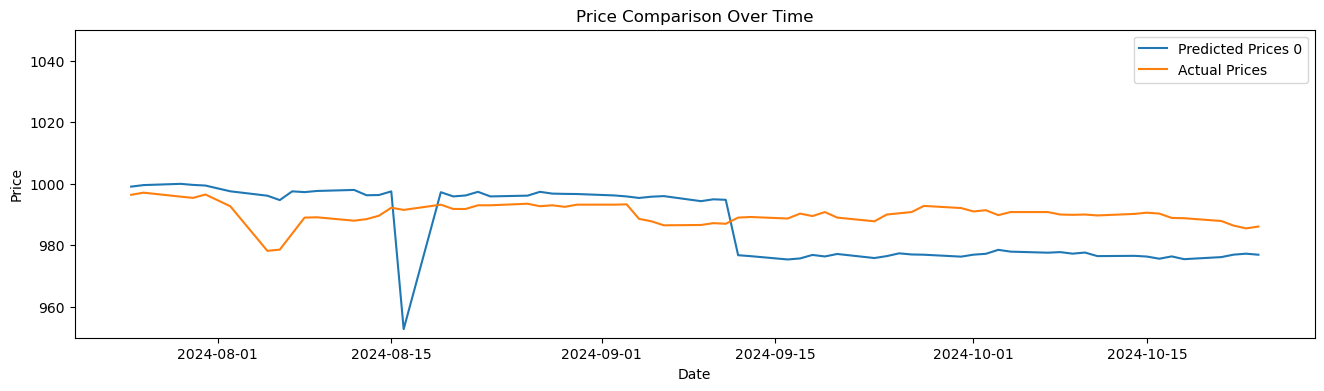

In [10]:
evaluation_plot(
    backtest_start, backtest_end, combined_df, [prices], ylim=(950, 1050)
)

with open('../output/heston_ts_qe.pkl', 'wb') as file:
    pickle.dump(prices, file)